## 250607 LCEL

* HyperClova X 기반 bogosa 복원 완료
* 원 agent가 대답할 수 있던 문제를 어느 정도 수준으로 대답할 수 있는지 테스트 중
* 이미지 시각화를 위한 parsed_image 추가

In [1]:
import os
import re
import json
import jsonlines
from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from uuid import uuid4
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

import pandas as pd
import pytz

from datasets import Dataset
from datetime import timedelta
from operator import itemgetter
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
  AttributeInfo,
  StructuredQueryOutputParser,
  get_query_constructor_prompt
)
from langchain_teddynote.evaluator import GroundednessChecker
from langchain.retrievers.self_query.milvus import MilvusTranslator
from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda
import warnings
from langchain_core.runnables import chain

warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
embeddings = ClovaXEmbeddings(
    model='bge-m3'
)

In [4]:
from datetime import datetime
from typing import Optional
from pydantic import BaseModel
import instructor
from pydantic import BaseModel, Field, field_validator
from typing import Literal


class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(
        description="The reasoning process used to evaluate the relevance"
    )
    relevancy: int = Field(
        description="Relevancy score from 0 to 10, where 10 is most relevant",
        ge=0,
        le=10,
    )

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

In [5]:
def adjust_time_filter_to_week(time_filter):
    """
    특정 날짜(YYYY-MM-DD)가 주어진 경우, 해당 날짜를 포함하는 주(월~일)의
    첫 번째 날(월요일)과 마지막 날(일요일)로 변환하는 함수.

    :param time_filter: dict, {"start_date": datetime, "end_date": datetime}
    :return: dict, {"start_date": datetime, "end_date": datetime}
    """
    # Extract start_date and end_date from time_filter
    start_date = time_filter.start_date
    end_date = time_filter.end_date

    # Handle the case where start_date or end_date is None
    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())  # 월요일 찾기
            end_of_week = start_of_week + timedelta(days=6)  # 해당 주 일요일 찾기

            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())  # 월요일 찾기
            end_of_week = start_of_week + timedelta(days=6)  # 해당 주 일요일 찾기

            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None  # or return the time_filter as is if you prefer

    # 날짜가 동일한 경우, 주의 첫 번째 날(월요일)과 마지막 날(일요일)로 변경
    if start_date.year == end_date.year and start_date.month==end_date.month and start_date.day==end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())  # 월요일 찾기
        end_of_week = start_of_week + timedelta(days=6)  # 해당 주 일요일 찾기

        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    # 날짜가 다르면 기존 time_filter 유지
    return {
        "start_date": start_date,
        "end_date": end_date
    }

In [6]:
def parse_search_query_response(response: str, question: str) -> SearchQuery:
    """
    ChatClovaX 응답을 SearchQuery 객체로 파싱
    """
    try:
        # 응답이 JSON 문자열이라고 가정
        data = json.loads(response.content)
        # time_filter가 null이면 빈 dict으로 변환
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        # query 필드가 없으면 원본 question을 사용
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception:
        # 파싱 실패 시, 기본값 반환
        return SearchQuery(query=question, time_filter=TimeFilter())


In [7]:
def get_query_date(question):
    today = datetime(2025, 1, 25)
    days_since_last_friday = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_since_last_friday)
    issue_date = last_friday.strftime("%Y-%m-%d")

    # ChatClovaX 인스턴스 생성
    chat = ChatClovaX(
        model="HCX-005",
        temperature = 0
    )

    # 프롬프트: 반드시 SearchQuery 포맷(JSON)으로만 답변하게 유도
    system_prompt = f"""
    You are an AI assistant that extracts date ranges from financial queries.
    The current report date is {issue_date}.
    Your task is to extract the relevant date or date range from the user's query
    and format it in YYYY-MM-DD format.
    If no date is specified, answer with None value.
    Return your answer as a JSON object in this format:
    {{
        "query": "<원본 질문>",
        "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
    }}
    답변은 반드시 위 JSON 형태로만 해.
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
    ]
    
    response = chat.invoke(messages)
    # ChatClovaX 응답을 SearchQuery로 파싱
    search_query = parse_search_query_response(response, question)

    # adjust_time_filter_to_week는 기존 함수 그대로 사용
    parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

    if parsed_dates:
        start = parsed_dates['start_date']
        end = parsed_dates['end_date']
    else:
        start = None
        end = None

    if start is None or end is None:
        expr = None
    else:
        expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
    return expr


In [8]:
def get_query_date(question):
    today = datetime(2025, 1, 25)
    days_since_last_friday = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_since_last_friday)
    issue_date = last_friday.strftime("%Y-%m-%d")

    # ChatClovaX 인스턴스 생성
    chat = ChatClovaX(
        model="HCX-005",
        temperature = 0
    )

    # 프롬프트: 반드시 SearchQuery 포맷(JSON)으로만 답변하게 유도
    system_prompt = f"""
    You are an AI assistant that extracts date ranges from financial queries.
    The current report date is {issue_date}.
    Your task is to extract the relevant date or date range from the user's query
    and format it in YYYY-MM-DD format.
    If no date is specified, answer with None value.
    Return your answer as a JSON object in this format:
    {{
        "query": "<원본 질문>",
        "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
    }}
    답변은 반드시 위 JSON 형태로만 해.
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
    ]
    
    response = chat.invoke(messages)
    # ChatClovaX 응답을 SearchQuery로 파싱
    search_query = parse_search_query_response(response, question)

    # adjust_time_filter_to_week는 기존 함수 그대로 사용
    parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

    if parsed_dates:
        start = parsed_dates['start_date']
        end = parsed_dates['end_date']
    else:
        start = None
        end = None

    if start is None or end is None:
        expr = None
    else:
        expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
    return expr


In [9]:
def convert_to_list(example):
    if isinstance(example["contexts"], list):
        contexts = example["contexts"]
    else:
        try:
            contexts = json.loads(example["contexts"])
        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {example['contexts']} - {e}")
            contexts = []
    return {"contexts": contexts}

text_prompt = PromptTemplate.from_template(
'''
today is '2025-01-25'. You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
If question has date expressions, context already filtered with the date expression, so ignore about the date and answer without it.
Answer in Korean. Answer in detail.

#Question:
{question}
#Context:
{context}

#Answer:'''
)


In [10]:
# 평가 결과 모델
class GroundnessQuestionScore(BaseModel):
    score: str = Field(
        description="질문과 답변이 명확히 관련 있으면 'yes', 아니면 'no'"
    )

class GroundnessAnswerRetrievalScore(BaseModel):
    score: str = Field(
        description="검색된 문서와 답변이 명확히 관련 있으면 'yes', 아니면 'no'"
    )

class GroundnessQuestionRetrievalScore(BaseModel):
    score: str = Field(
        description="검색된 문서와 질문이 명확히 관련 있으면 'yes', 아니면 'no'"
    )

class GroundednessCheckerClovaX:
    """
    HyperCLOVA X 기반의 정확성 평가기 (OpenAI 버전과 동일한 구조)
    """

    def __init__(self, llm, target="retrieval-answer"):
        self.llm = llm
        self.target = target


    def create(self):
        # 프롬프트 선택
        if self.target == "retrieval-answer":
            template = """
                You are a grader assessing relevance of a retrieved document to a user question.
                Here is the retrieved document: {context}
                Here is the answer: {answer}
                If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant.
                Return your answer as a JSON object: {{"score": "yes"}} or {{"score": "no"}}.
                답변은 반드시 위 JSON 형태로만 해.
            """
            input_vars = ["context", "answer"]
        elif self.target == "question-answer":
            template = """
                You are a grader assessing whether an answer appropriately addresses the given question.
                Here is the question: {question}
                Here is the answer: {answer}
                If the answer directly addresses the question and provides relevant information, grade it as relevant.
                Consider both semantic meaning and factual accuracy in your assessment.
                Return your answer as a JSON object: {{"score": "yes"}} or {{"score": "no"}}.
                답변은 반드시 위 JSON 형태로만 해.
            """
            input_vars = ["question", "answer"]
        elif self.target == "question-retrieval":
            template = """
                You are a grader assessing whether a retrieved document is relevant to the given question.
                Here is the question: {question}
                Here is the retrieved document: {context}
                If the document contains information that could help answer the question, grade it as relevant.
                Consider both semantic meaning and potential usefulness for answering the question.
                Return your answer as a JSON object: {{"score": "yes"}} or {{"score": "no"}}.
                답변은 반드시 위 JSON 형태로만 해.
            """
            input_vars = ["question", "context"]
        else:
            raise ValueError(f"Invalid target: {self.target}")

        def chain_func(**kwargs):
            prompt = template.format(**{k: kwargs[k] for k in input_vars})
            messages = [
                {"role": "system", "content": prompt}
            ]
            response = self.llm.invoke(messages)
            # 응답에서 yes/no만 추출
            answer = response.content.strip().replace('"', '').replace("'", "").lower()
            if answer not in ["yes", "no"]:
                import re
                match = re.search(r'\b(yes|no)\b', answer)
                if match:
                    answer = match.group(1)
                else:
                    raise ValueError(f"Invalid response: {response}")

            # Pydantic 모델 매핑
            if self.target == "retrieval-answer":
                return GroundnessAnswerRetrievalScore(score=answer)
            elif self.target == "question-answer":
                return GroundnessQuestionScore(score=answer)
            elif self.target == "question-retrieval":
                return GroundnessQuestionRetrievalScore(score=answer)

        return chain_func


In [11]:
question_answer_relevant = GroundednessCheckerClovaX(
  llm=ChatClovaX(model="HCX-005"), target='question-answer'
).create()

@chain
def kill_table(result):
    if question_answer_relevant(question=result['question'], answer=result['text']).score == 'no':
        result['context'] = table_chain.invoke({'question': result['question']})
    else:
        result['context'] = result['text']
    return result

In [12]:
URI = 'http://127.0.0.1:19530'

text_db = Milvus(
    embedding_function=embeddings,
    connection_args = {'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args = {'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args = {'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args = {'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

In [13]:
filepath = './chunked_jsonl/text_semantic_per_80.jsonl'

splitted_doc_text = []
with open(filepath, 'r', encoding='utf-8') as file:
    for line in file:
        if line.startswith('\n('):
            continue
        data = json.loads(line)

        doc = Document(
            page_content=data['page_content'],
            metadata=data['metadata']
        )
        splitted_doc_text.append(doc)

filepath = './chunked_jsonl/table_v7.jsonl'

splitted_doc_table = []
with open(filepath, 'r', encoding='utf-8') as file:
    for line in file:
        if line.startswith('\n('):
            continue
        data = json.loads(line)

        doc = Document(
            page_content=data['page_content'],
            metadata=data['metadata']
        )
        splitted_doc_table.append(doc)

In [14]:
bm25_retriever_table = KiwiBM25Retriever.from_documents(
    splitted_doc_table
)

bm25_retriever_table.k = 20

In [15]:
bm25_retriever_text = KiwiBM25Retriever.from_documents(
    splitted_doc_text
)
bm25_retriever_text.k = 50

bm25_2_retriever_text = KiwiBM25Retriever.from_documents(
    splitted_doc_text
)
bm25_2_retriever_text.k = 5

In [16]:
def format_docs(docs):
    # 각 문서의 issue_date와 page_content를 함께 출력하도록 포맷합니다.
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

In [17]:
table_prompt = PromptTemplate.from_template(
'''You are an assistant for question-answering tasks.
Use the following pieces of retrieved table to answer the question.
If you don't know the answer, just say that you don't know.
Answer in Korean. Answer in detail.

#Question:
{question}
#Context:
{context}

#Answer:'''
)

In [18]:
llm = ChatClovaX(model='HCX-005', temperature=0)

answer = []

text_chain = (
    RunnableParallel(
        question=itemgetter('question')
    ).assign(expr = lambda x: get_query_date(x['question'])
    ).assign(context_raw=lambda x: RunnableLambda(
            lambda _: text_db.as_retriever(
                search_kwargs={'expr': x['expr'], 'k': 25}
            ).invoke(x['question'])
        ).invoke({}),
    ).assign(
        formatted_context=lambda x: format_docs(x['context_raw'])
    )
    | RunnableLambda(
        lambda x: {
            "question": x['question'],
            "context": x['formatted_context'],  
        }
    )
    | text_prompt
    | llm
    | StrOutputParser()
)

In [19]:
table_chain = (
    RunnableParallel(
        question=itemgetter('question')
    ).assign(expr = lambda x: get_query_date(x['question'])
    ).assign(milvus=lambda x: RunnableLambda(
            lambda _: table_db.as_retriever(
                search_kwargs={'expr': x['expr'], 'k': 10}
            ).invoke(x['question'])
        ).invoke({}),
        bm25_raw=lambda x: bm25_retriever_table.invoke(x['question'])
    ).assign(
        bm25_filtered=lambda x: [
            doc for doc in x["bm25_raw"]
            if not x["expr"] or (
                x["expr"].split("'")[1] <= doc.metadata.get("issue_date", "") <= x["expr"].split("'")[3]
            )
        ],
    ).assign(
        context=lambda x: x['milvus'] + x['bm25_filtered']
    )
    | RunnableLambda(
        lambda x: {
            "question": x['question'],
            "context": x['context'],
        }
    )
    | table_prompt
    | llm
    | StrOutputParser()
)

In [20]:
general_prompt = PromptTemplate.from_template(
  '''You are question-answering AI chatbot about financial reports.
  주어진 두 개의 정보는 table과 text에서 가져온 정보들이야. 이 정보를 바탕으로 질문에 대해 자세히 설명해줘.
  
  If one of the table or text says it doesn't know or it can't answer, don't mention with that.
  And some questions may not be answered simply with context, but rather require inference. In those cases, answer by inference. 
  
  #Question:
  {question}

  #Text Answer:
  {text}

  #Table Answer:
  {table}
  '''
)

In [21]:
general_chain = (
    RunnableParallel(
        question=RunnablePassthrough(),
        text=text_chain,
        table=table_chain,
    )
    | general_prompt 
    | llm
)


predict_chain = (
    RunnableParallel(
        question=RunnablePassthrough(),
        text=text_chain,
        table=table_chain,
    )
    | general_prompt 
    | llm
)

In [22]:
metadata_field_info = [
  AttributeInfo(
    name='source',
    description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
    type='string',
  ),
]

prompt_query = get_query_constructor_prompt(
  'summary of weekly financial report about bonds',
  metadata_field_info
)

output_parser = StructuredQueryOutputParser.from_components()
query_constructor = prompt_query | llm | output_parser


prompt_raptor = PromptTemplate.from_template(
'''You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Answer in Korean. Answer in detail.
If the context mentions an unrelated date, do not mention that part.
Summarize and organize your answers based on the various issues that apply to the period.

#Question:
{question}
#Context:
{context}

#Answer:'''
)

In [23]:
retriever_raptor = SelfQueryRetriever(
  query_constructor=query_constructor,
  vectorstore=raptor_db,
  structured_query_translator=MilvusTranslator(),
  search_kwargs={'k': 10}
)

raptor_chain = (
    RunnableParallel(
        question=itemgetter('question')
    ).assign(expr = lambda x: get_query_date(x['question'])
    ).assign(context=lambda x: retriever_raptor.invoke(x['question']))
    | RunnableLambda(
        lambda x: {
            "question": x['question'],
            "context": x['context'],
        }
    )
    | prompt_raptor
    | llm
)


raptor_date_chain = (
    RunnableParallel(
        question=itemgetter('question')
    ).assign(expr = lambda x: get_query_date(x['question'])
    ).assign(context=lambda x: RunnableLambda(
            lambda _: raptor_db.as_retriever(
                search_kwargs={'expr': x['expr'], 'k': 10}
            ).invoke(x['question'])
        ).invoke({})
    )
    | RunnableLambda(
        lambda x: {
            "question": x['question'],
            "context": x['context'],
        }
    )
    | prompt_raptor
    | llm
)

In [24]:
prompt_routing = PromptTemplate.from_template(
  '''주어진 사용자 질문을 `요약`, `예측`, 또는 `일반` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
  
  <question>
  {question}
  </question>
  
  Classification:'''
)

chain_routing = (
  {'question': RunnablePassthrough()}
  | prompt_routing
  | llm
  | StrOutputParser()
)

prompt_routing_2 = PromptTemplate.from_template(
  '''주어진 사용자 질문을 `날짜`, `호수` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
  
  <question>
  {question}
  </question>
  
  Classification:'''
)

chain_routing_2 = (
  {'question': RunnablePassthrough()}
  | prompt_routing_2
  | llm
  | StrOutputParser()
)

In [25]:
def route_2(info):
  if '날짜' in info['topic'].lower():
    return raptor_date_chain
  else:
    return raptor_chain
  
def route(info):
  if '요약' in info['topic'].lower():
    return route_2(info)
  elif '예측' in info['topic'].lower():
    return predict_chain
  else:
    return general_chain


full_chain = (
  {'topic': chain_routing, 'question': itemgetter('question')}
  | RunnableLambda(
    route
  )
  | StrOutputParser()
)

In [26]:
retriever_image = image_db.as_retriever(search_kwargs={'k': 3})

retrieval_answer_relevant = GroundednessCheckerClovaX(
  llm, target='retrieval-answer'
).create()


In [27]:
import matplotlib.pyplot as plt
from matplotlib import rc
from PIL import Image

def ask(question):
    expr = get_query_date(question)
    answer = full_chain.invoke({'question': question})
    print(answer)
    rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False        
    context = retriever_image.invoke(question, expr=expr)
    for i in context:
        rar = retrieval_answer_relevant(context=i, answer=answer)
        if rar.score=='yes':
            plt.title('참고 자료')
            image_path = i.metadata['image'].replace('raw_pdf_copy3', 'parsed_pdf')
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

In [28]:
ask('연준의 비공식 대변인은?')

질문에 대한 답변을 드리겠습니다.

연준(Federal Reserve System)의 비공식 대변인은 월스트리트 저널의 기자로 활동하고 있는 닉 티미라오스(Nick Timiraos)입니다. 그는 여러 문서와 보도에서 연준의 비공식 대변인으로 언급되며, 그의 분석 및 보고서는 금융 시장에서 중요한 정보원으로 인정받고 있습니다. 닉 티미라오스는 연준의 정책 방향에 관한 핵심적인 정보를 전달하는 역할을 하며, 그의 발언이 금융 시장에 큰 영향을 미칠 수 있다고 평가되고 있습니다. 이러한 이유로 인해 그가 연준의 비공식 대변인으로서의 역할은 상당히 중요하다고 할 수 있습니다.

참고로, 테이블에는 해당 정보가 포함되어 있지 않아 답변드릴 수 없다는 점을 알려드립니다. 그러나 본문 내용을 기반으로 한 위의 답변이 도움이 되었기를 바랍니다. 추가 질문이나 다른 주제에 대해 궁금한 부분이 있으시다면 언제든지 말씀해 주세요!


질문에 대한 답변을 종합적으로 제공하겠습니다.

먼저, Text Answer에 따르면 2주 전인 2025년 1월 10일에 발행된 은행채는 **2조 6,100억 원**입니다.

한편, Table Answer에서는 2025년 1월 3일부터 9일까지의 은행채 발행액에 관한 세부 내역이 제시되어 있습니다. 이를 요약하자면:

- 1월 6일에는 3,400억 원,
- 1월 7일에는 700억 원,
- 1월 9일에는 4,000억 원이 각각 발행되었습니다.

이를 모두 합치면 1월 3일부터 9일까지 총 **11,700억 원**의 은행채가 발행되었음을 알 수 있습니다.

정리하자면, 질문하신 시점(2주 전)을 기준으로 한 특정 일자에 해당하는 발행액은 **2조 6,100억 원**, 그리고 그 이전 일주일간의 발행액 합계는 **11,700억 원**이라는 점을 확인할 수 있습니다. 따라서 두 답변 간 금액 차이가 존재하는데, 이는 아마도 다른 시점을 기준으로 하거나 혹은 다른 범위의 데이터를 참조했기 때문일 가능성이 큽니다.


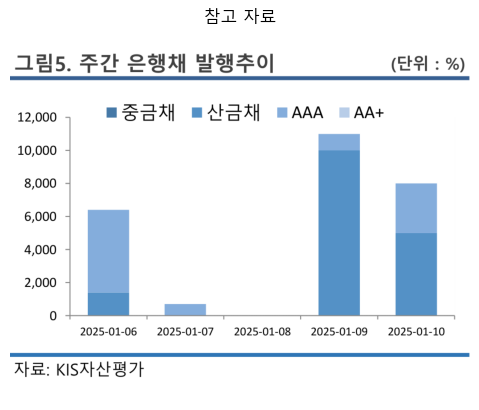

In [30]:
ask('2주전 은행채 발행액은?')

In [35]:
ask('2025년 1월 24일과 2025년 1월 17일의 국공채 시장 동향을 비교하시오.')

Based on the provided information from both the text and table answers, here is a detailed comparison of the trends in the government bond market between January 24th and January 17th, 2025:

**Similarities:**

Both dates saw overall stability in the government bond market with slight decreases in yields across most regions. For instance, US Treasury showed a general decline trend, while Germany's Bundesbank (DEUTSCHLAND REP) and Japan Government bonds displayed upward trends.

**Differences:**

1. Spread Changes:
   - On January 17th, there was more volatility observed especially after the release of the US Consumer Price Index (CPI), which led to fluctuations in the American bond market.
   - By contrast, January 24th witnessed fewer significant changes as investors seemed content with the current yield levels without any major economic news driving the markets.

2. Issuance Trends:
   - During January 17th, bank bonds continued their issuance growth, with spreads narrowing across al

In [32]:
ask('지난 달 은행채 발행액 총액은?')

질문에 대한 답변은 다음과 같습니다:

지난달인 **2024년 12월의 은행채 발행액 총액**은 **4조 5,800억 원**입니다. 이는 텍스트 답변을 통해 확인할 수 있는 내용으로, 구체적인 출처로는 2024년 1월 24일 자료가 언급되었습니다.

한편, 표를 통해서도 유사한 시기의 은행채 발행내역 일부를 확인할 수 있으나, 이는 전체 기간을 포괄하지 않아 정확한 총액을 산출하기에는 무리가 따릅니다. 다만, 제시된 예시기간(2025년 1월 6일~24일)의 발행액을 모두 합산한 결과값이 약 **1,450억 원**이므로, 이를 토대로 유추컨대 최근 몇 년간의 월평균 발행규모와 비교하여 상대적으로 큰 변동이 없는 한, 질문 시점에서의 월간 발행총액 역시 이와 비슷한 수준일 것으로 예상됩니다.

정확한 수치 파악을 위해서는 보다 많은 정보가 필요하겠지만, 현재로서는 텍스트 답변이 가장 신뢰할 만한 출처라고 판단됩니다.


In [33]:
ask('1101호 요약해줘')

문서 내용에 따르면, 11월의 ABS(자산유동화증권) 유통시장에서의 발행 동향은 다음과 같이 정리할 수 있습니다:

1. **기초자산 및 유통시장 현황**
   - Primary CBO, 단말기할부대금채권, 기타 유형 등으로 구성됨.
   - 부동산 관련 자산은 통합 분류되고, 여러 신용 파생 구조 상품들이 포함됨.

2. **ABCP 및 ABSTB 발행 현황**
   - ABCP는 15.5조원으로 전월보다 7.1조원 줄었고, ABSTB는 22.9조원으로 전월 대비 3.2조원 늘어남.
   - 정기예금 기반 단기증권은 A1등급만 발행되어, 발행액이 약 8.9조원에 달함.

3. **발행 만기와 기초자산 별 발행 비중**
   - 다양한 만기의 정기예금 유동화 단기증권이 발행됨.
   - 국내은행이 모든 발행을 담당하였고, 외국계나 중국계 은행은 참여하지 않음.

4. **PF 및 부동산 관련 발행 상황**
   - PF 및 부동산 관련 ABCP와 ABSTB의 발행액은 각각 2.5조원과 12.2조원이었음.
   - PF 유동화 단기증권은 전체 유동화 단기증권에서 차지하는 비중이 38%로, 전월 대비 4%포인트 증가한 것으로 나타남.

이와 같은 내용으로, 본 문서는 11월 ABS 시장의 발행 동향과 기초자산별, 발행 기관별 분포를 자세히 분석하고 있습니다.


In [34]:
ask('다음달 회사채 시장과 스프레드 전망 알려줘')

현재 제공된 정보로는 다음 달의 회사채 시장 및 스프레드의 구체적인 전망에 대해서는 직접적인 답변을 드릴 수는 없지만, 몇 가지 일반적인 원칙과 접근 방법을 안내드릴 수 있습니다.

1. **경제적 요인**: 경제 성장률, 인플레이션, 실업률 등의 거시경제 지표는 채권시장 전반에 걸쳐 영향을 미칩니다. 예를 들어, 경제 성장이 둔화되면 안전 자산으로 여겨지는 채권에 대한 수요가 증가하면서 채권 가격이 상승하고, 반대로 스프레드는 줄어들 수 있습니다.

2. **중앙은행의 통화정책**: 각국의 중앙은행이 설정하는 금리 수준은 채권 수익률 곡선에 큰 영향을 줍니다. 금리가 상승하면 신규 발행되는 채권의 수익률이 높아지고, 이는 기존 채권의 상대적 가치를 낮출 수 있으며 결과적으로 스프레드가 확대될 가능성이 있습니다.

3. **기업 신용도**: 개별 기업의 신용위험은 그 회사가 발행한 회사채의 스프레드에 직접적인 영향을 미칩니다. 신용등급이 낮은 기업은 더 높은 리스크 프리미엄을 요구하게 되므로, 이들의 채권 스프레드는 상대적으로 넓어질 수 있습니다.

4. **금융시장의 전반적인 분위기**: 투자자들의 심리, 시장의 유동성 등도 채권 스프레드를 결정짓는 중요한 요소입니다. 금융 시장이 불안정하거나 유동성이 감소하면, 투자자들은 보다 안전한 자산을 선호하게 되어 고위험 회사채의 스프레드가 늘어날 수 있습니다.

이러한 요인들을 종합적으로 고려하여 시장 상황을 판단하고, 필요한 경우 금융 전문가의 분석을 참고하거나 직접적인 시장 데이터에 접근하여 의사결정을 내리시는 것이 좋습니다. 또한, 정기적으로 금융 뉴스와 리포트를 확인함으로써 최신 동향을 파악하는 것이 중요합니다. 투자 시에는 개인의 투자 목표와 위험 감수 능력을 항상 염두에 두고 신중히 결정하시기 바랍니다.
